In [1]:
%cd ..

d:\HUST\20232\ML\Project_OCR\HandwritingRecognition


In [2]:
import torch.nn as nn
import torch
from torchsummary import summary

# VGG

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class VGG_FeatureExtractor(nn.Module):
    """ FeatureExtractor of CRNN (https://arxiv.org/pdf/1507.05717.pdf) """

    def __init__(self, input_channel, output_channel=512):
        super(VGG_FeatureExtractor, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]  # [64, 128, 256, 512]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 64x16x50
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 128x8x25
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),  # 256x8x25
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 256x4x25
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),  # 512x4x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 512x2x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True)
        )  # 512x1x24

    def forward(self, input):
        return self.ConvNet(input)

In [10]:
vgg = VGG_FeatureExtractor(1, 512)

In [12]:
input = torch.rand((64, 1, 32, 800))
output = vgg(input)
output.shape

torch.Size([64, 512, 1, 199])

# BiLSTM

In [13]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

# Model

In [14]:

class CRNN_vgg(nn.Module):

    def __init__(self, num_class, input_channel, output_channel, hidden_size):
        super(CRNN_vgg, self).__init__()
        """ FeatureExtraction """
        self.FeatureExtraction = VGG_FeatureExtractor(input_channel, output_channel)
        # elif opt.FeatureExtraction == 'RCNN':
        #     self.FeatureExtraction = RCNN_FeatureExtractor(opt.input_channel, opt.output_channel)
        # elif opt.FeatureExtraction == 'ResNet':
        #     self.FeatureExtraction = ResNet_FeatureExtractor(opt.input_channel, opt.output_channel)
        
        self.FeatureExtraction_output = output_channel  # int(imgH/16-1) * 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))  # Transform final (imgH/16-1) -> 1

        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(
                BidirectionalLSTM(self.FeatureExtraction_output, hidden_size, hidden_size),
                BidirectionalLSTM(hidden_size, hidden_size, hidden_size))
        self.SequenceModeling_output = hidden_size
        
        """ Prediction """
        self.Prediction = nn.Linear(self.SequenceModeling_output, num_class)
        
    def forward(self, input):
        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        contextual_feature = self.SequenceModeling(visual_feature)
        
        """ Prediction stage """
        prediction = self.Prediction(contextual_feature.contiguous())
        
        return prediction


In [15]:
model = Model(155, 1, 512, 200)

In [16]:
output = model(input)
output.shape

torch.Size([64, 199, 155])

# Test model

In [4]:
from model.crnn import CRNN
from model.MyCrnn import MyCRNN
from dataset import *
from utils.StrLabelConverter import *

import os

from dataset_v2 import DatasetImg_v2
from dataset import DatasetImg

In [8]:
class Parser:
    def __init__(self):
        self.dstype = 'v2'
        self.root = 'data/data_v1'
        self.imgW = 800
        self.alphabet = 'data/char_v1.txt'
        self.model = 'CRNN'
        self.num_hidden = 200
        self.dropout = 0.1
        self.lr = 0.001
        self.batch_size = 8
        self.nepochs = 100
        self.valInterval = 1
        self.saveInterval = 1
        self.savedir = 'checkpoint'

In [9]:
opt = Parser()

In [16]:
device = ( "cuda" if torch.cuda.is_available() else "cpu")
print("---------------------------------------------------")
print(f"Using {device} device")
print("---------------------------------------------------")

# --------------Tạo Dataset -------------------------------------------------------
if opt.dstype == 'v1':
    print('Sử dụng dataset_v1')
    train_dataset = DatasetImg(opt.root + '/train/img', opt.root + '/train/label', imgW=opt.imgW)
    test_dataset = DatasetImg(opt.root + '/test/img', opt.root + '/test/label', imgW=opt.imgW)
elif opt.dstype == 'v2':
    print('Sử dụng dataset_v2')
    train_dataset = DatasetImg_v2(opt.root + '/train/img', opt.root + '/train/label')
    test_dataset = DatasetImg_v2(opt.root + '/test/img', opt.root + '/test/label')

with open(os.path.join(opt.alphabet), 'r', encoding='utf-8') as f:
    alphabet = f.read().rstrip()

converter = StrLabelConverter(alphabet)
print('Num class: ', converter.numClass)

---------------------------------------------------
Using cpu device
---------------------------------------------------
Sử dụng dataset_v2
Num class:  154


In [17]:
indices = list(range(64))
subset = torch.utils.data.Subset(train_dataset, indices)

train_dataloader = torch.utils.data.DataLoader(subset,
                    batch_size=16,
                    shuffle=True )

In [18]:
if opt.model == 'MyCRNN':
    model = MyCRNN(converter.numClass, opt.num_hidden, opt.dropout).to(device)
elif opt.model == 'CRNN':
    model = CRNN(converter.numClass, opt.num_hidden).to(device)

criterion = torch.nn.CTCLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

>>>> use CRNN-------------



In [19]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42) # Comment lại để cho khởi tạo tham số ngẫu nhiên

In [20]:
from tqdm import tqdm
from utils.utils import GetInputCTCLoss
model = CRNN(converter.numClass, opt.num_hidden).to(device)

criterion = torch.nn.CTCLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
log = []
# Training----------------------------------------------------------------------------------
for epoch in range(1, 10 ):
    print('Epoch: ', epoch)
    # Train -------------------------
    model.train(True)
    total_loss = 0
    levenshtein_loss = 0

    t = tqdm(iter(train_dataloader), total=len(train_dataloader))
    for batch_idx, (imgs, labels) in enumerate(t):
        params_list = list(model.parameters())
        log.append(params_list)
        imgs = imgs.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        
        preds_, preds_lengths, targets, target_lengths = GetInputCTCLoss(converter, preds, labels)
        loss = criterion(preds_.log_softmax(2), targets, preds_lengths, target_lengths) # ctc_loss chỉ dùng với cpu, dùng với gpu phức tạp hơn thì phải
        assert (not torch.isnan(loss) and not torch.isinf(loss)), "Loss value is NaN or Inf"
        
        # Backward -------------------------------------------------
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().item()

        _, enc_preds = preds.max(2)
        sim_preds = converter.decode(enc_preds.view(-1), preds_lengths, raw = False)
        print(sim_preds)
        levenshtein_loss += converter.Levenshtein_loss(sim_preds, labels)

    total_loss = total_loss/train_dataloader.sampler.num_samples *opt.batch_size
    levenshtein_loss = levenshtein_loss/train_dataloader.sampler.num_samples 
    print('Epoch: [{}/{}]\t avg_Loss/batch = {:.4f} \t Levenshtein_Loss/sentence = {:.2f}'.format(epoch, 1 + opt.nepochs, total_loss, levenshtein_loss))
    # log.append({
    #     'type': 'train',
    #     'epoch': epoch,
    #     'avg_Loss': total_loss,
    #     'levenshtein_Loss': levenshtein_loss
    # })


>>>> use CRNN-------------

Epoch:  1


 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

['UUUUUU', 'UUUUUUUUUUUUU', 'UUUUU', 'UUUUU', 'UUUUUUUUUUUUUU', 'UUU', 'UUUUUUUUUU', 'UU', 'UUUUUUUUUUUU', 'UUUUUUUU', 'UUUUUUUUUU', 'UUUUU', 'UUUUUUUUUUU', 'UUUUUUUUUUU', 'UUUU', 'UU']


 50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:08<00:02,  2.84s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [1/101]	 avg_Loss/batch = 5.5638 	 Levenshtein_Loss/sentence = 73.61
Epoch:  2


 25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:08<00:02,  2.69s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [2/101]	 avg_Loss/batch = 5.2982 	 Levenshtein_Loss/sentence = 73.61
Epoch:  3


 25%|██▌       | 1/4 [00:02<00:07,  2.63s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:05<00:05,  2.70s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:08<00:02,  2.76s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [3/101]	 avg_Loss/batch = 4.8580 	 Levenshtein_Loss/sentence = 73.61
Epoch:  4


 25%|██▌       | 1/4 [00:02<00:08,  2.79s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:08<00:03,  3.03s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [4/101]	 avg_Loss/batch = 4.1880 	 Levenshtein_Loss/sentence = 73.61
Epoch:  5


 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:06<00:06,  3.17s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:10<00:03,  3.45s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:13<00:00,  3.50s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [5/101]	 avg_Loss/batch = 3.2643 	 Levenshtein_Loss/sentence = 73.61
Epoch:  6


 25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [6/101]	 avg_Loss/batch = 2.4548 	 Levenshtein_Loss/sentence = 73.61
Epoch:  7


 25%|██▌       | 1/4 [00:03<00:09,  3.22s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:06<00:06,  3.07s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:09<00:03,  3.07s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [7/101]	 avg_Loss/batch = 2.2036 	 Levenshtein_Loss/sentence = 73.61
Epoch:  8


 25%|██▌       | 1/4 [00:03<00:09,  3.16s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:06<00:06,  3.13s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 75%|███████▌  | 3/4 [00:09<00:03,  3.22s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch: [8/101]	 avg_Loss/batch = 2.2575 	 Levenshtein_Loss/sentence = 73.61
Epoch:  9


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:07<00:07,  3.79s/it]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


 50%|█████     | 2/4 [00:11<00:11,  5.56s/it]


KeyboardInterrupt: 

## TEST

In [64]:
from tqdm import tqdm
from utils.utils import *

with torch.no_grad():
    avg_loss = 0
    avg_levenshtein_loss = 0

    t = tqdm(iter(trainer.test_dataloader), total=len(trainer.test_dataloader))
    for batch_idx, (imgs, labels) in enumerate(t):
        imgs = imgs.to(trainer.device)
        preds = model(imgs)
        print(imgs)
        # Compute Loss -------------------------------------------
        preds_, preds_lengths, targets, target_lengths = GetInputCTCLoss(trainer.converter, preds, labels)
        loss = trainer.criterion(preds_.log_softmax(2), targets, preds_lengths, target_lengths) # ctc_loss chỉ dùng với cpu, dùng với gpu phức tạp hơn thì phải
        avg_loss += loss.detach().item()

        _, enc_preds = preds.max(2)
        sim_preds = trainer.converter.decode(enc_preds.view(-1), preds_lengths, raw = False)
        avg_levenshtein_loss += trainer.converter.Levenshtein_loss(sim_preds, labels)
        print(sim_preds)
        break

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

  0%|          | 0/3 [00:05<?, ?it/s]

['ỨậỨĂỨậỨậỨ0', 'ỨậỨ0', 'ỨậỨ0', 'ỨậỨ0', 'Ứ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨ0', 'Ứ0', 'Ứ0', 'ỨậĂỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậ.ỨậỨậĂỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'ỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậĂậỨậỨĂậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨĂỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨ0', 'ỨậỨậỨ0', 'ỨậỨậĂỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'ỨậỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨ0', 'ỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨ0', 'Ứ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨậỨậỨ0', 'ỨậỨậỨậỨ0', 'ỨậĂậỨậỨĂỨậĂậĂỨậỨậỨĂậỨậỨ0', 'ỨậỨậỨậỨ0']


In [46]:
labels

('Số 1 Phạm Hùng, Phường Dịch Vọng Hậu, Quận Cầu Giấy, Hà Nội',
 '45 Đường Số 27 P.Tân Phong, Phường Tân Phong, Quận 7, TP Hồ Chí Minh',
 '9/9 (644), quốc lộ 1A, P4, Phường 4, Thành Phố Tân An, Long An',
 '316 Lê Văn Sỹ, Phường 1, Quận Tân Bình, TP Hồ Chí Minh',
 'Xã Quảng Hùng, Huyện Quảng Xương, Thanh Hoá',
 'Số 29 Đường 320 Bông Sao, Phường 5, Quận 8, TP Hồ Chí Minh',
 '64/31 Nguyên Hồng, Phường 1, Quận Gò Vấp, TP Hồ Chí Minh',
 'Bình Thắng, Xã Bình Thắng, Huyện Bù Gia Mập, Bình Phước',
 '387 Đào Trí, Phường Phú Thuận, Quận 7, TP Hồ Chí Minh',
 'Thôn Thượng Giang, Xã Tây Giang, Huyện Tây Sơn, Bình Định',
 '375 Thuỵ Khuê, phường Bưởi, Quận Tây Hồ, Hà Nội',
 'Số 459, phố Kim Ngưu, Phường Vĩnh Tuy, Quận Hai Bà Trưng, Hà Nội',
 'ấp Chánh, Xã Đức Lập Hạ, Huyện Đức Hoà, Long An',
 'Số 04 Lê Phụng Hiểu, Phường Lam Sơn, Thành Phố Thanh Hoá, Thanh Hoá',
 '95A Nguyễn Du, Thị trấn Ea Súp, Huyện Ea Súp, Đắc Lắc',
 '121B Trần Nhật Duật, Phường Phước Hòa, Thành phố Nha Trang, Khánh Hòa',
 '384 Ho

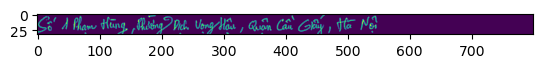

In [43]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0][0])
plt.show()

# Build

In [4]:

class CRNN(nn.Module):

    def __init__(self, nclass, num_hidden, dropout = 0):
        super(CRNN, self).__init__()

        ks = [ 3,   3,   3,   3,   3,   3,   1,   1,   1]
        ss = [ 1,   1,   1,   1,   1,   1,   1,   1,   1]
        ps = [ 1,   1,   1,   1,   1,   1,   1,   1,   1]
        nm = [64, 128, 256, 256, 256, 512, 512, 512, 512]

        cnn = nn.Sequential()
        def convRelu(i):
            nIn = 1 if i == 0 else nm[i - 1] 
            nOut = nm[i]
            # cnn.add_module('conv{0}'.format(i),
            #                nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            cnn.add_module('conv{0}'.format(i), nn.Conv2d(nIn, nOut, 3, 1, 1))
            cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        # input : (C, H, W) - (1, 32, 512)
        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d((2, 2)))  # 64, 16, 256
        convRelu(1) 
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d((2, 2)))  # 128, 8, 128
        convRelu(2) 
        convRelu(3) 
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d((2, 1)))  # 256, 4, 128
        convRelu(4) 
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3), nn.MaxPool2d((2, 1)))  # 512, 2, 128
        convRelu(6) 
        convRelu(7)
        cnn.add_module('pooling{0}'.format(4), nn.MaxPool2d((2, 1)))  # 512, 1, 128

        self.cnn = cnn

        # BiLSTM
        self.biLSTM1 = nn.LSTM(512, num_hidden, bidirectional=True, batch_first = True)
        self.dropout1 = nn.Dropout(dropout)

        self.linear = nn.Linear(num_hidden * 2, nclass, bias = True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        # conv features
        x1 = self.cnn(input) # b, 512, 1, 128
        x1 = torch.squeeze(x1, 2) # b, 512, 128
        x1 = x1.permute(0, 2, 1)  # b, 128, 512

        x2, _  = self.biLSTM1(x1) # b, 128, num_hidden*2
        x2 = self.dropout1(x2) 

        x3 = self.linear(x2) # b, 128, num_class
        out = self.dropout(x3)

        return out


In [5]:
cnn_ = CRNN(124, 100)
out = cnn_(torch.rand(64, 1, 32, 512))
out.shape

torch.Size([64, 128, 124])

In [6]:
cnn_

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [5]:
for name, param in cnn_.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Layer: cnn.conv0.weight | Size: torch.Size([64, 1, 3, 3]) | Values : tensor([[[[ 0.1159, -0.0922, -0.0774],
          [-0.0084, -0.2158,  0.0290],
          [-0.3093,  0.2286, -0.3006]]],


        [[[-0.0702,  0.1410, -0.0326],
          [ 0.2566,  0.0519,  0.0762],
          [-0.1566,  0.0275, -0.0293]]]], grad_fn=<SliceBackward0>) 

Layer: cnn.conv0.bias | Size: torch.Size([64]) | Values : tensor([-0.2395,  0.2840], grad_fn=<SliceBackward0>) 

Layer: cnn.batchnorm0.weight | Size: torch.Size([64]) | Values : tensor([1., 1.], grad_fn=<SliceBackward0>) 

Layer: cnn.batchnorm0.bias | Size: torch.Size([64]) | Values : tensor([0., 0.], grad_fn=<SliceBackward0>) 

Layer: cnn.conv1.weight | Size: torch.Size([128, 64, 3, 3]) | Values : tensor([[[[ 0.0385, -0.0375, -0.0349],
          [ 0.0327, -0.0155, -0.0409],
          [-0.0165, -0.0222, -0.0108]],

         [[ 0.0355,  0.0303,  0.0415],
          [ 0.0296,  0.0169, -0.0204],
          [ 0.0227, -0.0389,  0.0119]],

         [[ 0.0374,  0

# Fix model with data/2

In [4]:
from model.crnn import CRNN
from utils.utils import *
import torch

In [5]:
dataset = DatasetImg('data/2/img', 'data/2/label', 512, 32)

In [10]:
dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=4,
                    shuffle=True)

In [6]:
with open(os.path.join('data/char.txt'), 'r', encoding='utf-8') as f:
    alphabet = f.read().rstrip()
# print(alphabet)
converter = strLabelConverter(alphabet, ignore_case=True)


In [7]:
model = CRNN(converter.numClass, 100, 0.1)

criterion = torch.nn.CTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
epoch = 0
checkpoint_path = 'pretrain/model_3.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [16]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


cnn.conv0.weight tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, 

In [13]:
imgs, labels = next(iter(dataloader))
targets, target_lenghts = converter.encode(labels)

optimizer.zero_grad()

preds = model(imgs)

b, l, c = preds.shape
preds_ = preds.permute(1, 0, 2)
preds_lengths = torch.full(size=(b,), fill_value=l, dtype=torch.long).to('cpu')

loss = criterion(preds_.log_softmax(2), targets, preds_lengths, target_lenghts) # ctc_loss chỉ dùng với cpu, dùng với gpu phức tạp hơn thì phải
loss

tensor(nan, grad_fn=<MeanBackward0>)

In [ ]:
loss = criterion(preds_.log_softmax(2), targets, preds_lengths, target_lenghts) # ctc_loss chỉ dùng với cpu, dùng với gpu phức tạp hơn thì phải
            

In [16]:
class Example:
    def __init__(self, list_data):
        self.data = list_data
    
    def modify_data(self, new_item):
        self.data.append(new_item)

# Tạo một list
my_list = [1, 2, 3]

# Tạo một đối tượng của class Example, truyền my_list vào
example_obj = Example(my_list)

# In dữ liệu ban đầu
print("Dữ liệu ban đầu:", example_obj.data)

# Sử dụng phương thức của class để thay đổi dữ liệu
example_obj.modify_data(4)

# In dữ liệu sau khi thay đổi
print("Dữ liệu sau khi thay đổi:", example_obj.data)
print("Dữ liệu gốc cũng thay đổi:", my_list)


Dữ liệu ban đầu: [1, 2, 3]
Dữ liệu sau khi thay đổi: [1, 2, 3, 4]
Dữ liệu gốc cũng thay đổi: [1, 2, 3, 4]
